# Example 2 Gaussian Distribution

Consider a data set to be modeled as a gaussian distribution where the mean, $\mu$, and variance $\sigma$ of the distribution are unknown.

Assume that the parameter priors are given by,

$
\begin{align}
\mu    &\sim \mathcal{U}(l_\mu, h_\mu) \\
\sigma &\sim \mathcal{HN}(\sigma_\sigma)
\end{align}
\tag{1}
$

where $\mathcal{U}(l_\mu, h_\mu)$ is a Uniform distribution between $l_\mu$ amd $h_\mu$ and $\mathcal{HN}(\sigma_\sigma)$ a HalfNormal distribution with scale $\sigma_\sigma$. 
The distribution of the data is assumed to have the form,

$
\begin{align}
Y \sim \mathcal{N}(\mu, \sigma)
\end{align}
\tag{2}
$

It follows that the likelihood function is given by,

$
\begin{align}
P[Y\, | \mu,\sigma] = \frac{1}{\sigma\sqrt{2\pi}}e^{\left(\frac{\left(y - \mu\right)}{\sigma}\right)^2}
\end{align}
\tag{3}
$

In [1]:
%reload_ext autoreload
%autoreload 2

# import system modules and set local import path
import os
import sys
import numpy
from matplotlib import pyplot
from scipy import stats
import pymc
import arviz

sys.path.insert(0, os.path.abspath('../..'))

from lib import config
from lib.plots import (curve, comparison, bar, twinx_bar_line, fcurve_scatter_comparison, positive_negative_bar)

pyplot.style.use(config.glyfish_style)

In [40]:
mu_true = 50
sigma_true = 5

l_mu, h_mu = 40, 75
mu_prob = 1.0 / (h_mu - l_mu)
sigma_sigma = 5

mu_vals = numpy.linspace(0, 100, 100)
sigma_vals = numpy.linspace(-10, 10, 50)

mu_pdf = numpy.where((mu_vals >= l_mu) & (mu_vals <= h_mu), mu_prob, 0)
sigma_pdf = numpy.abs(stats.norm.pdf(sigma_vals, 0, sigma_sigma))

obs_data = numpy.random.normal(mu_true, sigma_true, 100)

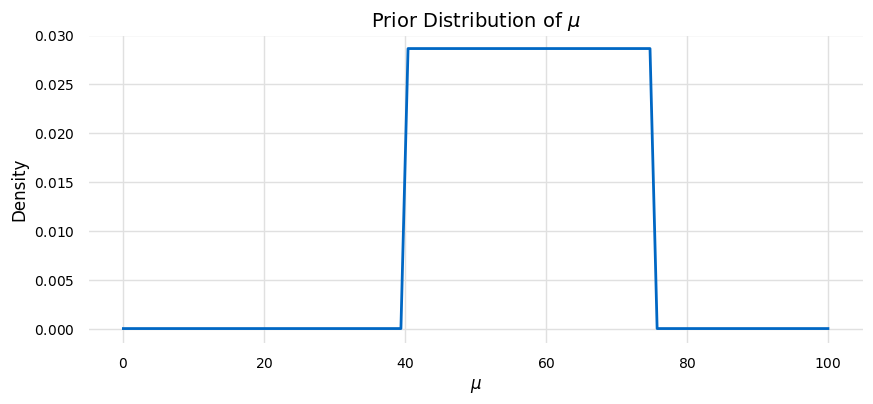

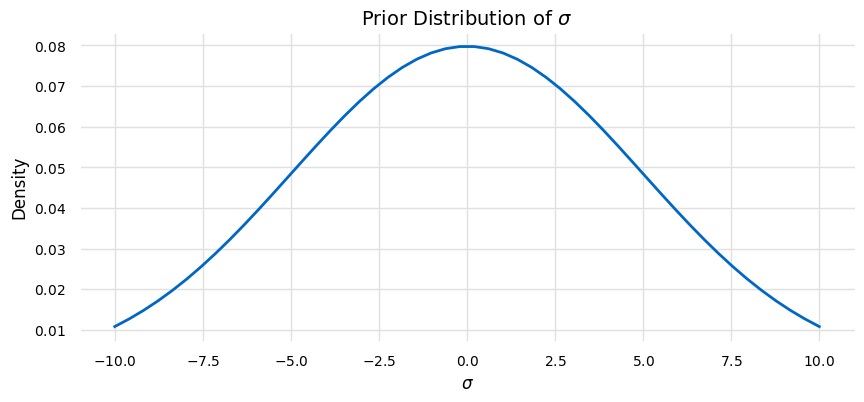

In [23]:
title = 'Prior Distribution of $\mu$'
curve(mu_pdf, mu_vals, title=title, xlabel='$\mu$', ylabel='Density', figsize=(10, 4))

title = 'Prior Distribution of $\sigma$'
curve(sigma_pdf, sigma_vals, title=title, xlabel='$\sigma$', ylabel='Density', figsize=(10, 4))


## pyMC

In [41]:
with pymc.Model() as model:
    mu = pymc.Uniform('mu', l_mu, h_mu)
    sigma = pymc.HalfNormal('sigma', sigma=sigma_sigma)
    data = pymc.Normal('data', mu=mu, sigma=sigma, observed=obs_data)

    idata = pymc.sample(1000, tune=1000, chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


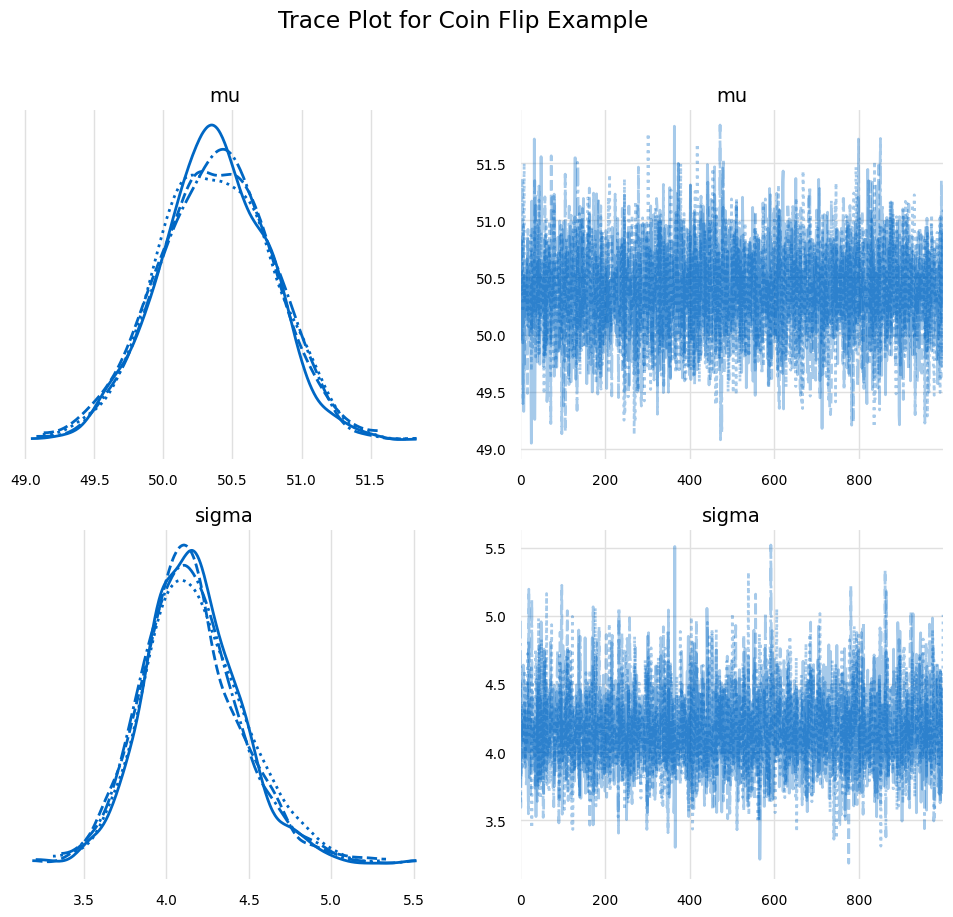

In [42]:
arviz.plot_trace(idata, figsize=(12, 10))
_ = pyplot.suptitle('Trace Plot for Coin Flip Example')

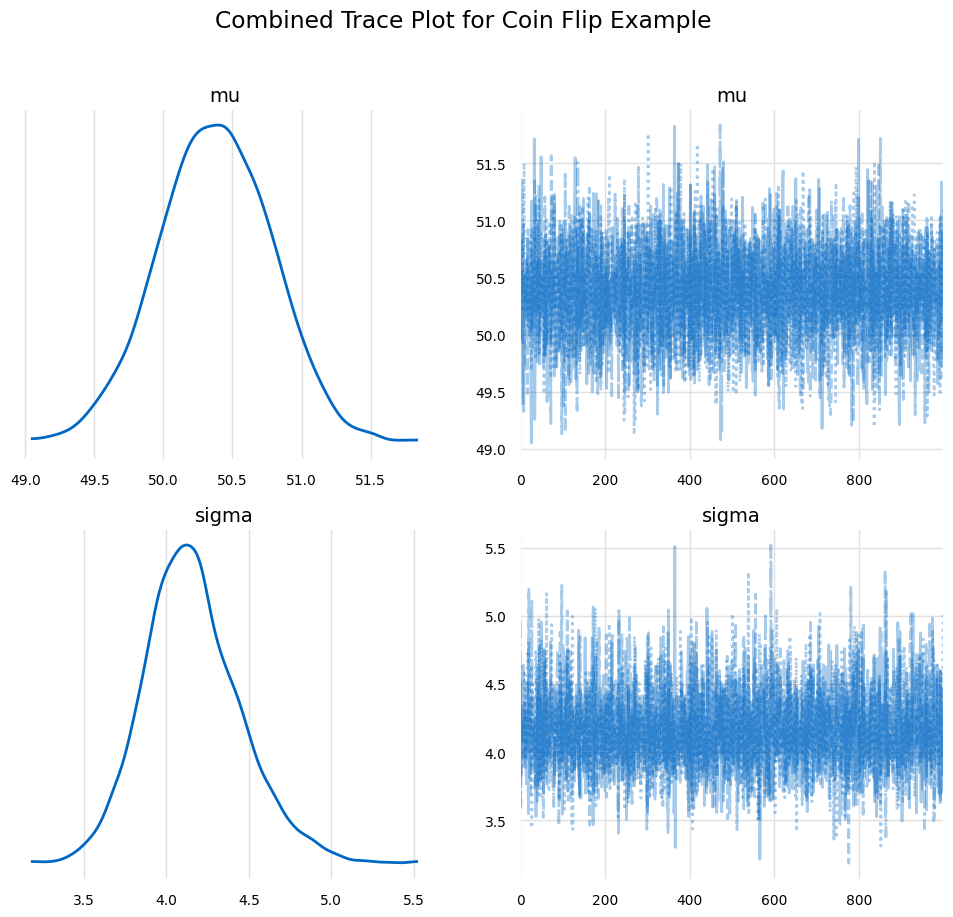

In [43]:
arviz.plot_trace(idata, figsize=(12, 10), combined=True)
_ = pyplot.suptitle('Combined Trace Plot for Coin Flip Example')

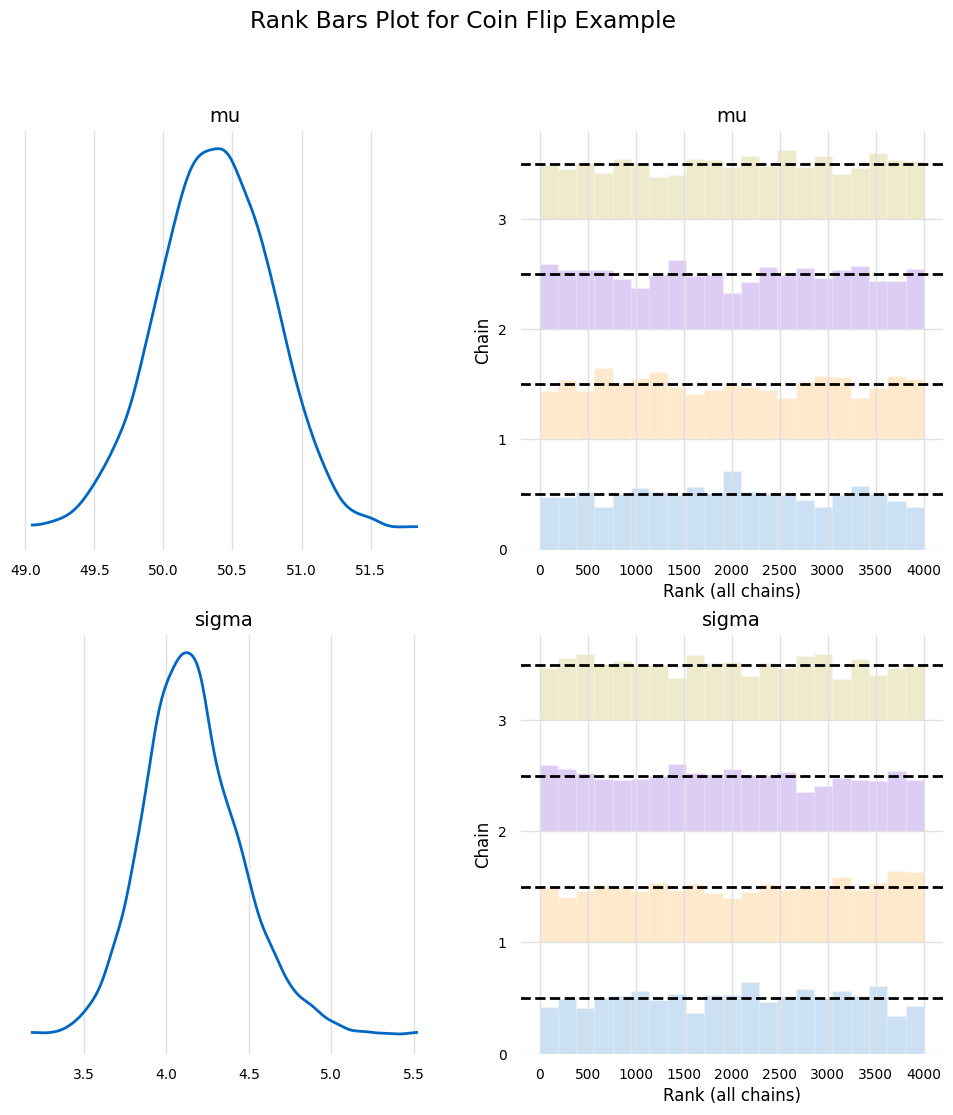

In [46]:
arviz.plot_trace(idata, kind='rank_bars', combined=True, figsize=(12, 12))
_ = pyplot.suptitle('Rank Bars Plot for Coin Flip Example') 

In [45]:
arviz.summary(idata).round(2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,50.38,0.41,49.59,51.13,0.01,0.0,4402.0,2964.0,1.0
sigma,4.16,0.29,3.60,4.71,0.00,0.0,4398.0,2918.0,1.0
